# Spectral PERT graphs

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph




Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
from numpyarray_to_latex import to_ltx
from numpyarray_to_latex.jupyter import to_jup

def descomposicion_SVD(rutas):
  U, S, VT = np.linalg.svd(rutas, full_matrices=True)

  # Create a diagonal matrix from S (singular values)
  S = np.diag(S)

  # Pad the diagonal matrix to match the original dimensions of rutas
  m, n = rutas.shape
  if m > n:
      # If m > n, pad with zeros to make S_full m x m
      S = np.pad(S, ((0, m - n), (0, 0)), mode='constant')
  elif m < n:
      # If m < n, pad with zeros to make S_full n x n
      S = np.pad(S, ((0, 0), (0, n - m)), mode='constant')
  return {'U': U, 'S': S, 'VT':VT}

def pretty(x, dec=0, latex=False, **kwds):
  if latex:
    pretty_function = to_ltx
  else:
    pretty_function = to_jup

  if dec == 0:
    try:
      result = pretty_function(x, fmt='{:d}', **kwds)
    except:
      result = pretty_function(x, fmt=f'{{:.{dec}f}}', **kwds)
  else:
    result = pretty_function(x, fmt=f'{{:.{dec}f}}', **kwds)

  return result

def pretty_latex(x, dec=0, **kwds):
  return pretty(x, dec=dec, latex=True, **kwds)

def beautify(*args):
  converter = lambda x: pretty_latex(x) if isinstance(x, np.ndarray) or isinstance(x, pd.DataFrame) else str(x)
  return Latex(' '.join([converter(arg) for arg in args]))

def tanto_por_uno(x):
  return np.abs(x) / np.abs(x).sum()

def ordena_rutas(rutas, importancia_actividades, importancia_rutas):
  def highlight_positive(val):
    color = 'background-color: yellow' if val > 0 else ''
    return color

  rutas = rutas * importancia_actividades
  sorted_indices = np.flip(np.argsort(importancia_actividades))
  rutas = rutas.iloc[:, sorted_indices ]

  rutas['Importancia'] = importancia_rutas
  rutas = rutas.sort_values('Importancia', ascending=False)

  rutas = rutas.style.map(lambda x: '' if pd.Series(x).name == 'Importancia' else highlight_positive(x), subset=rutas.columns.drop('Importancia'))

  return rutas



### Definición del Grafo

In [3]:
# Alargamos el ancho de las celdas a un tanto por ciento
from IPython.display import display, HTML, Markdown, Math, Latex, SVG
display(HTML("<style>.container { width:70% !important; }</style>"))
import pandas as pd
import numpy as np
import sympy as sym


datos_enunciado = pd.DataFrame(data=np.array([
       [ 8, 4, 2],
       [10, 5, 4],
       [12, 6, 3],
       [10, 6, 4],
       [ 7, 5, 5],
       [ 7, 4, 5],
       [14, 9, 3],
       [12, 8, 2],
       [10, 7, 1],
       ]),
   columns=['Dmax', 'Dtope', 'UCR'],
   index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'],
   dtype=np.int32)
datos_enunciado['predecessors'] = {
    "A": "---",
    "B": "---",
    "C": "---",
    "D": "A",
    "E": "B",
    "F": "C,D,E",
    "G": "A",
    "H": "B",
    "I": "F,G",
}

## Datos del enunciado

In [4]:
datos_enunciado

,Dmax,Dtope,UCR,predecessors
A,8,4,2,---
B,10,5,4,---
C,12,6,3,---
D,10,6,4,A
E,7,5,5,B
F,7,4,5,"C,D,E"
G,14,9,3,A
H,12,8,2,B
I,10,7,1,"F,G"


## Dibujo del PERT

In [5]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dict_of_strings(datos_proyecto['predecessors'])
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I
activities,,,,,,,,,
A,,,,,,,,,
B,,,,,,,,,
C,,,,,,,,,
D,True,,,,,,,,
E,,True,,,,,,,
F,,,True,True,True,,,,
G,True,,,,,,,,
H,,True,,,,,,,
I,,,,,,True,True,,


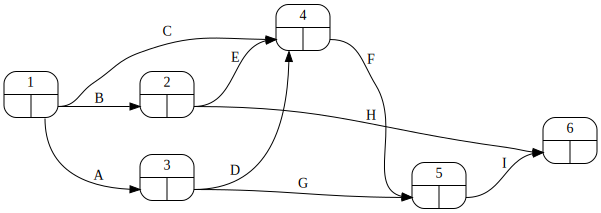

In [6]:
proyecto = prelaciones.create_project()
filename = "pert_inicial_sin_duraciones.svg"
proyecto.pert(filename, ranksep=1)

La tabla anterior, de prelaciones inmediatas, permite su lectura por filas y por columnas para comprobar que el grafo está correctamente dibujado.




## Cálculo de la lista completa de predecesores (todos los predecesores, no sólo los vecinos cercanos)

La tabla siguiente, de prelaciones distantes, proporciona la lista completa de predecesoras de cada actividad, y permite comprobar si dos grafos son equivalentes aunque su dibujo difiera.

In [7]:
prelaciones.distant_linkage_matrix

,A,B,C,D,E,F,G,H,I
activities,,,,,,,,,
A,,,,,,,,,
B,,,,,,,,,
C,,,,,,,,,
D,True,,,,,,,,
E,,True,,,,,,,
F,True,True,True,True,True,,,,
G,True,,,,,,,,
H,,True,,,,,,,
I,True,True,True,True,True,True,True,,


O equivalentemente, en otro formato condensado:

In [8]:
proyecto.distant_predecessor(format='DataFrame')

,predecessors
A,----
B,----
C,----
D,A
E,B
F,"A, B, C, D, E"
G,A
H,B
I,"A, B, C, D, E, F, G"


## Cálculo de la matriz de rutas

In [9]:
rutas = proyecto.path_matrix()
proyecto.display_path_matrix()

,A,B,C,D,E,F,G,H,I
Route_1,0,0,1,0,0,1,0,0,1
Route_2,0,1,0,0,1,1,0,0,1
Route_3,0,1,0,0,0,0,0,1,0
Route_4,1,0,0,1,0,1,0,0,1
Route_5,1,0,0,0,0,0,1,0,1


## Uso de la matriz de rutas para el cálculo de las duraciones máximas y mínimas del proyecto

In [10]:
duraciones = rutas @ datos_enunciado[['Dmax', 'Dtope']]
beautify(rutas, '\cdot', datos_enunciado[['Dmax', 'Dtope']], '=', duraciones)

<IPython.core.display.Latex object>

In [11]:
duraciones.max(axis='rows').to_frame().T

,Dmax,Dtope
0,35,21


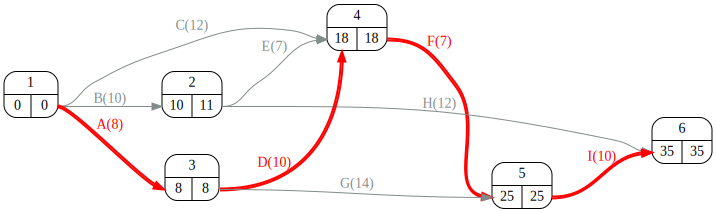

In [12]:
filename = "pert_con_duraciones_maximas.svg"
proyecto.pert(filename, durations=datos_enunciado['Dmax'], ranksep=1)

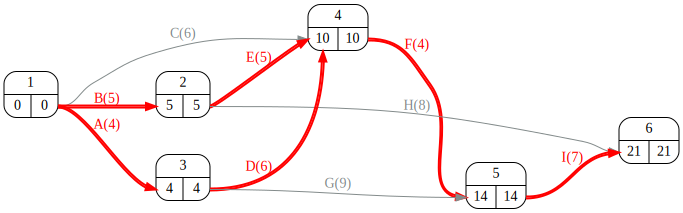

In [13]:
filename = "pert_con_duraciones_minimas.svg"
proyecto.pert(filename, durations=datos_enunciado['Dtope'], ranksep=1)

## Calculo de la descomposición SVD de la matriz de rutas


In [14]:
svd = descomposicion_SVD(rutas)
U = svd['U']
S = svd['S']
VT = svd['VT']

In [15]:
pretty(U, prefix='\mathrm{U} = ', dec=2)

<IPython.core.display.Math object>

In [16]:
pretty(S, prefix='\mathrm{S} = ', dec=1)

<IPython.core.display.Math object>

In [17]:
pretty(VT, prefix='\mathrm{V}^T = ', dec=2)

<IPython.core.display.Math object>

U codifica la importancia de los caminos:

In [18]:
pretty(U[:,0], is_row_vector=False, dec=2, prefix='\mathrm{U}_0=')

<IPython.core.display.Math object>

VT codifica la importancia de las actividades:

In [19]:
pretty(VT[0,:], dec=2, prefix='{\mathrm{V}^T}_0=')

<IPython.core.display.Math object>

In [20]:
importancia_actividades = tanto_por_uno(VT[0,:].round(2))
importancia_rutas = tanto_por_uno(U[:,0].round(2))

In [21]:
pretty(importancia_actividades, dec=2)

<IPython.core.display.Math object>

In [22]:
pretty(importancia_rutas, is_row_vector=False, dec=2)

<IPython.core.display.Math object>

In [23]:
rutas_ordenadas = ordena_rutas(rutas, importancia_actividades, importancia_rutas)
rutas_ordenadas

,I,F,A,B,D,E,C,G,H,Importancia
Route_4,0.273469,0.220408,0.134694,0.000000,0.081633,0.000000,0.000000,0.000000,0.000000,0.287805
Route_2,0.273469,0.220408,0.000000,0.085714,0.000000,0.073469,0.000000,0.000000,0.000000,0.263415
Route_1,0.273469,0.220408,0.000000,0.000000,0.000000,0.000000,0.065306,0.000000,0.000000,0.224390
Route_5,0.273469,0.000000,0.134694,0.000000,0.000000,0.000000,0.000000,0.053061,0.000000,0.185366
Route_3,0.000000,0.000000,0.000000,0.085714,0.000000,0.000000,0.000000,0.000000,0.012245,0.039024


### Cálculo del nucleo de la matriz de rutas

Este es el espacio generado por las filas de $V^T$ correspondientes a los valores singulares nulos de $R$.

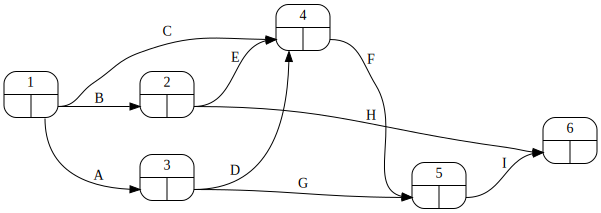

In [24]:
SVG("pert_inicial_sin_duraciones.svg")

In [25]:
nulo = np.zeros((9,4))

# nodo 2
nulo[[1]    ,0] = 1
nulo[[4, 7] ,0] = -1

# nodo 3
nulo[[0]    ,1] = 1
nulo[[3, 6] ,1] = -1

# nodo 4
nulo[[2, 3, 4] , 2] = 1
nulo[[5]       , 2] = -1

# nodo 5
nulo[[5, 6]    , 3] = 1
nulo[[8]       , 3] = -1
nulo

array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -1.,  1.,  0.],
       [-1.,  0.,  1.,  0.],
       [ 0.,  0., -1.,  1.],
       [ 0., -1.,  0.,  1.],
       [-1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.]])

In [26]:
rutas @ nulo

,0,1,2,3
Route_1,0.0,0.0,0.0,0.0
Route_2,0.0,0.0,0.0,0.0
Route_3,0.0,0.0,0.0,0.0
Route_4,0.0,0.0,0.0,0.0
Route_5,0.0,0.0,0.0,0.0
